In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torchvision.datasets as TVdatasets

import torchattacks
from torchattacks import PGD, FGSM

from tqdm.notebook import tqdm

### Load CIFAR-10 data

In [2]:
cifar10_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

cifar10_train_data = TVdatasets.CIFAR10(root="../data/", 
                                        train=True, 
                                        download=True, 
                                        transform=cifar10_transform)

cifar10_test_data = TVdatasets.CIFAR10(root="../data/", 
                                       train=False, 
                                       download=True, 
                                       transform=cifar10_transform)

num_train_samples = len(cifar10_train_data)
num_test_samples = len(cifar10_test_data)

print("Number of train samples:", num_train_samples)
print("Number of test samples:", num_test_samples)

Files already downloaded and verified
Files already downloaded and verified
Number of train samples: 50000
Number of test samples: 10000


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if device=='cuda' else {}

train_batch_size = 32
test_batch_size = 32

trainloader = torch.utils.data.DataLoader(dataset=cifar10_train_data,
                                         batch_size=train_batch_size,
                                         shuffle=True,
                                         **kwargs)

testloader = torch.utils.data.DataLoader(dataset=cifar10_test_data,
                                         batch_size=test_batch_size,
                                         shuffle=False,
                                        **kwargs)

### Model definition

In [4]:
class Holdout(nn.Module):
    def __init__(self):
        super(Holdout, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(64 * 5 * 5, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10)    
        )
        
    def forward(self, x):
        out = self.conv_layer(x)
        out = out.view(-1, 64*5*5)
        out = self.fc_layer(out)
        
        return out

model = Holdout().to(device)

# model.load_state_dict(torch.load("./checkpoint/holdout.pth"))
# model = model.eval().cuda()

In [5]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [6]:
pgd_attack = PGD(model, eps=8/255, alpha=2/255, steps=10)
fgsm_attack = FGSM(model, eps=8/255)

### Training Process

In [7]:
num_batches = len(cifar10_train_data) // train_batch_size
num_epochs = 5
loss_lst = []

for epoch in range(num_epochs):
    for itr, (batch_imgs, batch_labels) in enumerate(tqdm(trainloader)):
        batch_imgs = batch_imgs.to(device)
        batch_labels = batch_labels.to(device)
        
        batch_adv_imgs = pgd_attack(batch_imgs, batch_labels)
        
        X_train = torch.cat((batch_adv_imgs, batch_imgs), 0)   
        Y_train_gt = torch.cat((batch_labels, batch_labels), 0)

#         X_train = batch_imgs
#         Y_train_gt = batch_labels
        
        Y_train_pred = model(X_train)
        loss_val = loss(Y_train_pred, Y_train_gt)
        
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        
        if (itr + 1) % 100 == 0:
            print("Epoch [{}/{}], Iteration [{}/{}], Loss:{}".format(epoch+1, num_epochs, 
                                                                        itr+1, num_batches, 
                                                                        round(loss_val.item(),4)))
        
        loss_lst.append(loss_val.item())

model_save_path = '../cifar10_net.pth'
torch.save(model.state_dict(), model_save_path)

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [1/5], Iteration [100/1562], Loss:1.918
Epoch [1/5], Iteration [200/1562], Loss:1.969
Epoch [1/5], Iteration [300/1562], Loss:1.6493
Epoch [1/5], Iteration [400/1562], Loss:1.6181
Epoch [1/5], Iteration [500/1562], Loss:1.741
Epoch [1/5], Iteration [600/1562], Loss:1.7006
Epoch [1/5], Iteration [700/1562], Loss:1.6332
Epoch [1/5], Iteration [800/1562], Loss:1.5342
Epoch [1/5], Iteration [900/1562], Loss:1.7447
Epoch [1/5], Iteration [1000/1562], Loss:1.3729
Epoch [1/5], Iteration [1100/1562], Loss:1.4116
Epoch [1/5], Iteration [1200/1562], Loss:1.5364
Epoch [1/5], Iteration [1300/1562], Loss:1.6376
Epoch [1/5], Iteration [1400/1562], Loss:1.6865
Epoch [1/5], Iteration [1500/1562], Loss:1.4668


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [2/5], Iteration [100/1562], Loss:1.463
Epoch [2/5], Iteration [200/1562], Loss:1.4108
Epoch [2/5], Iteration [300/1562], Loss:1.4046
Epoch [2/5], Iteration [400/1562], Loss:1.5568
Epoch [2/5], Iteration [500/1562], Loss:1.3926
Epoch [2/5], Iteration [600/1562], Loss:1.5788
Epoch [2/5], Iteration [700/1562], Loss:1.4751
Epoch [2/5], Iteration [800/1562], Loss:1.4286
Epoch [2/5], Iteration [900/1562], Loss:1.6057
Epoch [2/5], Iteration [1000/1562], Loss:1.123
Epoch [2/5], Iteration [1100/1562], Loss:1.5468
Epoch [2/5], Iteration [1200/1562], Loss:1.3926
Epoch [2/5], Iteration [1300/1562], Loss:1.3147
Epoch [2/5], Iteration [1400/1562], Loss:1.4218
Epoch [2/5], Iteration [1500/1562], Loss:1.3303


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [3/5], Iteration [100/1562], Loss:1.2934
Epoch [3/5], Iteration [200/1562], Loss:1.148
Epoch [3/5], Iteration [300/1562], Loss:1.7131
Epoch [3/5], Iteration [400/1562], Loss:1.4047
Epoch [3/5], Iteration [500/1562], Loss:1.3032
Epoch [3/5], Iteration [600/1562], Loss:1.3252
Epoch [3/5], Iteration [700/1562], Loss:1.4205
Epoch [3/5], Iteration [800/1562], Loss:1.2804
Epoch [3/5], Iteration [900/1562], Loss:1.31
Epoch [3/5], Iteration [1000/1562], Loss:1.2771
Epoch [3/5], Iteration [1100/1562], Loss:1.1779
Epoch [3/5], Iteration [1200/1562], Loss:1.186
Epoch [3/5], Iteration [1300/1562], Loss:1.3194
Epoch [3/5], Iteration [1400/1562], Loss:1.4253
Epoch [3/5], Iteration [1500/1562], Loss:1.4131


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [4/5], Iteration [100/1562], Loss:1.0301
Epoch [4/5], Iteration [200/1562], Loss:1.0095
Epoch [4/5], Iteration [300/1562], Loss:1.4267
Epoch [4/5], Iteration [400/1562], Loss:1.3617
Epoch [4/5], Iteration [500/1562], Loss:1.0978
Epoch [4/5], Iteration [600/1562], Loss:1.2811
Epoch [4/5], Iteration [700/1562], Loss:1.3317
Epoch [4/5], Iteration [800/1562], Loss:1.1573
Epoch [4/5], Iteration [900/1562], Loss:1.3919
Epoch [4/5], Iteration [1000/1562], Loss:1.1622
Epoch [4/5], Iteration [1100/1562], Loss:1.4642
Epoch [4/5], Iteration [1200/1562], Loss:1.0367
Epoch [4/5], Iteration [1300/1562], Loss:1.2148
Epoch [4/5], Iteration [1400/1562], Loss:1.3865
Epoch [4/5], Iteration [1500/1562], Loss:1.226


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [5/5], Iteration [100/1562], Loss:1.1797
Epoch [5/5], Iteration [200/1562], Loss:1.2071
Epoch [5/5], Iteration [300/1562], Loss:1.1632
Epoch [5/5], Iteration [400/1562], Loss:0.9704
Epoch [5/5], Iteration [500/1562], Loss:1.0664
Epoch [5/5], Iteration [600/1562], Loss:1.3845
Epoch [5/5], Iteration [700/1562], Loss:1.2092
Epoch [5/5], Iteration [800/1562], Loss:1.5862
Epoch [5/5], Iteration [900/1562], Loss:1.1811
Epoch [5/5], Iteration [1000/1562], Loss:1.3756
Epoch [5/5], Iteration [1100/1562], Loss:1.3057
Epoch [5/5], Iteration [1200/1562], Loss:1.0341
Epoch [5/5], Iteration [1300/1562], Loss:1.2098
Epoch [5/5], Iteration [1400/1562], Loss:1.1523
Epoch [5/5], Iteration [1500/1562], Loss:1.299


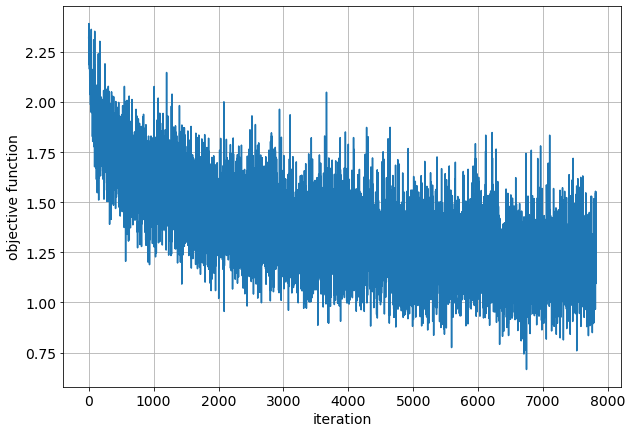

In [8]:
plt.figure(figsize=(10,7))
plt.plot(loss_lst)
plt.xlabel("iteration")
plt.ylabel("objective function")
plt.grid()
plt.show()

In [13]:
# pgd_attack = PGD(model, eps=8/255, alpha=2/255, steps=10)
# pgd_attack.set_return_type('int')
# pgd_attack.save(data_loader=testloader, save_path="./data/cifar10_pgd.pt", verbose=True)

In [15]:
# adv_imgs, adv_labels = torch.load("./data/cifar10_pgd.pt")
# adv_data = TensorDataset(adv_imgs.float() / 255.0, adv_labels)
# adv_loader = torch.utils.data.DataLoader(adv_data, batch_size=128, shuffle=False)

### Test accuracy (standard clean)

In [9]:
num_samples = 0
num_corr_pred = 0
model.eval()

with torch.no_grad():
    for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
        batch_imgs = batch_imgs.to(device)
        batch_labels = batch_labels.to(device)
#         print(batch_imgs.shape, batch_labels.shape)

        X_test = batch_imgs
        Y_test_gt = batch_labels

        _, Y_test_pred = torch.max(model(X_test), dim=1)

        num_samples += batch_imgs.shape[0]
        num_corr_pred += (Y_test_pred == Y_test_gt).sum()

test_accuracy = round(100.0 * float(num_corr_pred) / num_samples, 4)
print("Standard clean accuracy: {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Standard clean accuracy: 70.51 %


### Test accuracy (PGD attack)

In [10]:
num_samples = 0
num_corr_pred = 0
model.eval()

# with torch.no_grad():
for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)
#     print(batch_imgs.shape, batch_labels.shape)

    X_adv_pgd_imgs = pgd_attack(batch_imgs, batch_labels)

    X_test = X_adv_pgd_imgs
    Y_test_gt = batch_labels

    _, Y_test_pred = torch.max(model(X_test), dim=1)

    num_samples += batch_imgs.shape[0]
    num_corr_pred += (Y_test_pred == Y_test_gt).sum()
    
test_accuracy = round(100.0 * float(num_corr_pred) / num_samples, 4)
print("Robust accuracy (PGD attack): {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust accuracy (PGD attack): 38.24 %


### Test accuracy (FGSM attack)

In [11]:
num_samples = 0
num_corr_pred = 0
model.eval()

# with torch.no_grad():
for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
#     batch_imgs = transforms.functional.rgb_to_grayscale(batch_imgs, num_output_channels=1) 
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)
#     print(batch_imgs.shape, batch_labels.shape)

    X_adv_fgsm_imgs = fgsm_attack(batch_imgs, batch_labels)

    X_test = X_adv_fgsm_imgs
    Y_test_gt = batch_labels

    _, Y_test_pred = torch.max(model(X_test), dim=1)

    num_samples += batch_imgs.shape[0]
    num_corr_pred += (Y_test_pred == Y_test_gt).sum()
    
test_accuracy = round(100.0 * float(num_corr_pred) / num_samples, 4)
print("Robust accuracy (FGSM attack): {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust accuracy (FGSM attack): 46.92 %


### Test accuracy (FGSM + PGD attack)

In [12]:
num_samples = 0
num_corr_pred = 0
model.eval()

for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)
    
    X_adv_fgsm_imgs = fgsm_attack(batch_imgs, batch_labels)
    X_adv_pgd_imgs = pgd_attack(batch_imgs, batch_labels)
    
    X_test = torch.cat((X_adv_fgsm_imgs, X_adv_pgd_imgs), 0)
    Y_test_gt = torch.cat((batch_labels, batch_labels), 0)
    
    _, Y_test_pred = torch.max(model(X_test), dim=1)

    num_samples += Y_test_gt.shape[0]
    num_corr_pred += (Y_test_pred == Y_test_gt).sum()

test_accuracy = round(100.0 * float(num_corr_pred) / num_samples, 4)
print("Robust accuracy (FGSM + PGD attack): {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust accuracy (FGSM + PGD attack): 42.585 %
